# Influence of SCNA on polyG data

In [1]:
# loading functions
library(ggbeeswarm)
library(rstatix)
library(ggpubr)
library(wesanderson)
library(patchwork)
library(ggbreak)
library(gridExtra)
library(pheatmap)
library(scales)
library(ggtext)
library(readxl)
source("func.R")

Loading required package: ggplot2


Attaching package: 'rstatix'


The following object is masked from 'package:stats':

    filter


ggbreak v0.1.1

If you use ggbreak in published research, please cite the following
paper:

S Xu, M Chen, T Feng, L Zhan, L Zhou, G Yu. Use ggbreak to effectively
utilize plotting space to deal with large datasets and outliers.
Frontiers in Genetics. 2021, 12:774846. doi: 10.3389/fgene.2021.774846



Attaching package: 'ape'


The following object is masked from 'package:ggpubr':

    rotate


ggtree v3.7.2 For help: https://yulab-smu.top/treedata-book/

If you use the ggtree package suite in published research, please cite
the appropriate paper(s):

Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam.
ggtree: an R package for visualization and annotation of phylogenetic
trees with their covariates and other associated data. Methods in
Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628

Guangchuang Yu, Tommy Tsan-Yuk L

## Calculating new mutation rate without recurrently altered chromosomes:

In [2]:
# directroy of the results from the in-vitro evolution experiment
dir_list <-  list.files("../data/in_vitro_evolution/", 
                        pattern= "_R$", full.names=TRUE)


## Creating marker lengths table

Setting up function

In [3]:
# create a table to which others can be joined 
get_markerlengths  <- function(dir_list) { 
  
  markerlengths <- NULL
  
  for (dir in dir_list) {

    split_dir <- str_split(dir[1], "/", simplify = TRUE)

    subject <- split_dir[length(split_dir)]  %>%  str_split("_") %>% purrr::map(1) %>% unlist 
    
    ## path to poly-G raw data directory (marker length files)
    marker_dir <- paste0(dir, "/repre_repli_data/")

    ## load marker lengths and get the average length of each marker in each sample
  get_markers <- function(marker_dir) {

  marker <- suppressMessages(read_tsv(marker_dir))
  
  # getting the marker name
  int_file <- tail(str_split(marker_dir, "/")[[1]], 1) 
  marker_name <- head(str_split(int_file, "_")[[1]], 1)

  cols <- NCOL(marker) +1 

  marker  %>% 
    rowid_to_column("length")  %>% 
    pivot_longer(cols=c(2:cols), names_to="sample", values_to="Frequency")  %>% 
    group_by(sample)  %>% 
    mutate(Frequency=Frequency/sum(Frequency),
            sample=str_remove(sample, "_[1-3]$")) %>%
    summarize(length = sum(length * Frequency)) %>%
    mutate(marker=marker_name) 
    
  }
  
  marker_files <- list.files(marker_dir, full.names = TRUE)

  markers <- lapply(marker_files, get_markers)
  markers <- bind_rows(markers)

    
    # subtract marker length of normal from each marker   
    root_sample <- str_subset(unique(markers$sample), "M2|M3") 
    markers <- markers %>% 
      group_by(marker) %>% 
      filter(any(str_detect(sample, "M2|M3"))) %>% 
      mutate(length = length - length[str_detect(sample, "M2|M3")]) %>% 
      ungroup %>% 
      mutate(sample=str_remove(sample, "_[1-3]$"))  %>% 
      as.data.table
    
    markers$subject <- subject
    
    markerlengths <- bind_rows(markerlengths, markers) 
    
  }
  return(markerlengths)
}


## Removing markers on chr 7, 8, 13, 18, 20

In [32]:
pcr_primers <- read_tsv("../data/polyG_chr_positions.tsv")

Rows: 156 Columns: 2
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): id, chr



i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In https://doi.org/10.1038/nature11252, chromosomes 7, 8, 13, 18, and 20 were recurrently altered. We thus excluded those from this analysis.

In [33]:
drop_chr <- c("7", "8", "13", "18", "20")

In [36]:
keep_markers <- pcr_primers %>%
    filter(!(chr %in% drop_chr)) %>%
    pull(1)

In [40]:
markerlengths <- get_markerlengths(dir_list) %>%
     filter(str_remove(marker, "UA|LA") %in% keep_markers)

## Calculating L1 Distance

First getting all possible sample combinations

In [41]:
# find samples
samples <- markerlengths$sample %>% unique

combos_wide <- combn(samples, m= 2) %>% as.data.frame()

## make combo table longer
combos_long <- data.frame(a=as.character(combos_wide[1,]), b=as.character(combos_wide[2,]))

## remove all combintions where both primaries come from the same sample
combos <- combos_long %>% 
    mutate(sample_a=str_extract(a, "MSI|MSS"),
          sample_b=str_extract(b, "MSI|MSS"))  %>% 
    filter(sample_a==sample_b) %>% 
    dplyr::select(a, b)  

In [42]:
l1_list <- lapply(1:nrow(combos), get_l1_r_for_combination, combos, markerlengths)
l1_table  <- bind_rows(l1_list)

In [43]:
cell_divs_tbl <- read_xlsx("../data/cell_division_numbers.xlsx")

In [44]:
divs_tbl <- cell_divs_tbl %>%
    mutate(
        sample_name = str_remove_all(sample_name, "_"),
        sample_name = str_remove_all(sample_name, "MSI"), 
        sample_name = str_remove_all(sample_name, "MSS")
    )

In [45]:
# setting up a function to get the number of cell divisions from the previous sample to this sample
get_divs <- function(sample) {
    divs_tbl %>%
        filter(sample_name == sample) %>%
        pull(divisions)
}
# vectorizing this function to have it work in "mutate"
get_divs_vect <- Vectorize(get_divs)

The cell divisions need to be counted from the previous generation, as each sample only represent the expansion of mutations acquired while growing the previous sample:

In [46]:
 msi_generations  <- l1_table %>% 
  filter(str_detect(a, "MSI")) %>% 
  mutate(A=str_remove(a, "MSI1"), B=str_remove(b, "MSI1"),
      length_A=str_count(A), length_B=str_count(B)) %>% 
  # annotate how many generations separate sample A and B
  mutate(generations = case_when(
      # from root to first generation
       length_A ==  2 & B == "M2" ~ get_divs_vect(B),
      # from root to second generation
       length_A ==  4 & B == "M2" ~ get_divs_vect(B) + get_divs_vect(str_sub(A, 1, 2)),
      # from root to third generation
       length_A ==  6 & B == "M2" ~
         get_divs_vect(B) + get_divs_vect(str_sub(A, 1, 2)) + get_divs_vect(str_sub(A, 1, 4)),
      # within third generation
       length_A==length_B & str_detect(B, str_sub(A, 1,2)) ~ get_divs_vect((str_sub(A, 1,4)))*2,
      # between first and second generation of same clade
       str_detect(B, str_sub(A, 1, 2)) & length_A == 2 & length_B ==4 ~ get_divs_vect(A),
      # between second and third generation of same clade
       str_detect(B, str_sub(A, 1, 2)) & length_A == 4 & length_B ==6 ~ get_divs_vect(A),
      # between first and third generation of same clade
       str_detect(B, str_sub(A, 1,2)) & abs(length_A -length_B)==4 ~ get_divs_vect(str_sub(B, 1, 2)) +
       get_divs_vect(str_sub(B, 1, 4)),
      # between first generation
       length_A == length_B & !str_detect(B, "M2") & length_A == 2 ~ get_divs_vect("M2") * 2,
      # between second generation
       length_A == 4 & length_B == 4 & !str_detect(B, str_sub(A, 1, 2)) ~
          get_divs_vect("M2") * 2 + get_divs_vect(str_sub(A, 1, 2)) +
          get_divs_vect(str_sub(B, 1, 2)),
      # between third generation
       length_A == 6 & length_B == 6 & !str_detect(B, str_sub(A, 1, 2)) ~
          get_divs_vect("M2") * 2 + get_divs_vect(str_sub(A, 1, 2)) +
          get_divs_vect(str_sub(B, 1, 2)) + get_divs_vect(str_sub(A, 1, 4)) +
          get_divs_vect(str_sub(B, 1, 4)),
      # between second generation of one clade and third generation of another clade
        !str_detect(B, str_sub(A, 1, 2)) & length_A == 4 & length_B == 6 ~
            get_divs_vect("M2") * 2 + get_divs_vect(str_sub(A, 1, 2)) +
            get_divs_vect(str_sub(B, 1, 2)) + get_divs_vect(str_sub(B, 1, 4)),
      # between second generation of one clade and third generation of another clade, reversed A and B
        !str_detect(B, str_sub(A, 1, 2)) & length_A == 6 & length_B == 4 ~
            get_divs_vect("M2") * 2 + get_divs_vect(str_sub(B, 1, 2)) +
            get_divs_vect(str_sub(A, 1, 2)) + get_divs_vect(str_sub(A, 1, 4)),
      # between first generation of one clade and second generation of another clade
         !str_detect(B, str_sub(A, 1, 2)) & length_A == 2 & length_B == 4 ~
            get_divs_vect("M2") * 2 + get_divs_vect(str_sub(B, 1, 2)),
      # between first generation of one clade and second generation of another clade, reversed A and B
        !str_detect(B, str_sub(A, 1,2)) & length_A == 4 & length_B == 2 ~
            get_divs_vect("M2") * 2 + get_divs_vect(str_sub(A, 1, 2)),
     # between first generation of one clade and third generation of another clade
       !str_detect(B, str_sub(A, 1,2)) & length_A == 2 & length_B ==6 ~  get_divs_vect("M2") * 2 + 
         get_divs_vect(str_sub(B, 1, 2)) + get_divs_vect(str_sub(B, 1, 4)),
     # between first generation of one clade and third generation of another clade, reversed A and B
         !str_detect(B, str_sub(A, 1,2)) & length_A == 6 & length_B ==2 ~ get_divs_vect("M2") * 2 + 
            get_divs_vect(str_sub(A, 1, 2)) + get_divs_vect(str_sub(A, 1, 4))
  )) %>% 
  select(-c(length_A,length_B))

In [47]:
mss_generations  <- l1_table %>% 
  filter(str_detect(a, "MSS")) %>% 
  mutate(A=str_remove(a, "MSS1"), B=str_remove(b, "MSS1"),
      length_A=str_count(A), length_B=str_count(B)) %>% 
  # annotate how many generations separate sample A and B
  mutate(generations = case_when(
      # from root to first generation
       length_A ==  2 & B == "M3" ~ get_divs_vect(B) ,
      # from root to second generation
       length_A ==  4 & B == "M3" ~ get_divs_vect(B) + get_divs_vect(str_sub(A, 1, 2)),
      # from root to third generation
       length_A ==  6 & B == "M3" ~
         get_divs_vect(B) + get_divs_vect(str_sub(A, 1, 2)) + get_divs_vect(str_sub(A, 1, 4)),
      # within third generation
       length_A==length_B & str_detect(B, str_sub(A, 1,2)) ~ get_divs_vect((str_sub(A, 1,4)))*2,
      # between first and second generation of same clade
       str_detect(B, str_sub(A, 1, 2)) & length_A == 2 & length_B ==4 ~ get_divs_vect(A),
      # between second and third generation of same clade
       str_detect(B, str_sub(A, 1, 2)) & length_A == 4 & length_B ==6 ~ get_divs_vect(A),
      # between first and third generation of same clade
       str_detect(B, str_sub(A, 1,2)) & abs(length_A -length_B)==4 ~ get_divs_vect(str_sub(B, 1, 2)) +
       get_divs_vect(str_sub(B, 1, 4)),
      # between first generation
       length_A == length_B & !str_detect(B, "M3") & length_A == 2 ~ get_divs_vect("M3") * 2,
      # between second generation
       length_A == 4 & length_B == 4 & !str_detect(B, str_sub(A, 1, 2)) ~
          get_divs_vect("M3") * 2 + get_divs_vect(str_sub(A, 1, 2)) +
          get_divs_vect(str_sub(B, 1, 2)),
      # between third generation
       length_A == 6 & length_B == 6 & !str_detect(B, str_sub(A, 1, 2)) ~
          get_divs_vect("M3") * 2 + get_divs_vect(str_sub(A, 1, 2)) +
          get_divs_vect(str_sub(B, 1, 2)) + get_divs_vect(str_sub(A, 1, 4)) +
          get_divs_vect(str_sub(B, 1, 4)),
      # between second generation of one clade at third generation of another clade
        !str_detect(B, str_sub(A, 1, 2)) & length_A == 4 & length_B == 6 ~
            get_divs_vect("M3") * 2 + get_divs_vect(str_sub(A, 1, 2)) +
            get_divs_vect(str_sub(B, 1, 2)) + get_divs_vect(str_sub(B, 1, 4)),
      # between second generation of one clade at third generation of another clade, reversed A and B
        !str_detect(B, str_sub(A, 1, 2)) & length_A == 6 & length_B == 4 ~
            get_divs_vect("M3") * 2 + get_divs_vect(str_sub(B, 1, 2)) +
            get_divs_vect(str_sub(A, 1, 2)) + get_divs_vect(str_sub(A, 1, 4)),
      # between first generation of one clade at second generation of another clade
         !str_detect(B, str_sub(A, 1, 2)) & length_A == 2 & length_B == 4 ~
            get_divs_vect("M3") * 2 + get_divs_vect(str_sub(B, 1, 2)),
      # between first generation of one clade at second generation of another clade, reversed A and B
        !str_detect(B, str_sub(A, 1,2)) & length_A == 4 & length_B == 2 ~
            get_divs_vect("M3") * 2 + get_divs_vect(str_sub(A, 1, 2)),
     # between first generation of one clade at third generation of another clade
       !str_detect(B, str_sub(A, 1,2)) & length_A == 2 & length_B ==6 ~  get_divs_vect("M3") * 2 + 
         get_divs_vect(str_sub(B, 1, 2)) + get_divs_vect(str_sub(B, 1, 4)),
     # between first generation of one clade at third generation of another clade, reversed A and B
         !str_detect(B, str_sub(A, 1,2)) & length_A == 6 & length_B ==2 ~ get_divs_vect("M3") * 2 + 
            get_divs_vect(str_sub(A, 1, 2)) + get_divs_vect(str_sub(A, 1, 4))
  )) %>% 
  select(-c(length_A,length_B))

Getting updated mutation rates:

In [48]:
# calculating mutation rate based on slope
mu_msi <- coef((lm(msi_generations$l1 ~ msi_generations$generations)))[2]

In [49]:
# calculating mutation rate based on slope
mu_mss <- coef((lm(mss_generations$l1 ~ mss_generations$generations)))[2]

In [50]:
mu_msi
mu_mss

msi_generations$generations 
               0.0003768566

mss_generations$generations 
               0.0001137471

## Continueing with CRC data

In [52]:
crc_markerlengths <- read_tsv("../results/crc_markerlengths.tsv")

Rows: 11683 Columns: 4
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): sample, marker, subject
dbl (1): length

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


Removing markers on chr 7, 8, 13, 18, 20

In [53]:
crc_markerlengths <- crc_markerlengths %>%
   filter(str_remove(marker, "UA|LA") %in% keep_markers)

### Converting markerlengths into L1 distance and cell divisions

In [55]:
# getting intrapatient sample combinations

# find samples
samples <- crc_markerlengths$sample %>% unique

combos_wide <- combn(samples, m= 2) %>% as.data.frame()

## make combo table longer
combos_long <- data.frame(a=as.character(combos_wide[1,]), b=as.character(combos_wide[2,]))

## only use combintions from the same subject
combos <- combos_long %>% 
    mutate(sample_a=str_remove(a, "[N|P|M|L|Ad][:alnum:]+"),
          sample_b=str_remove(b, "[N|P|M|L|Ad][:alnum:]+"))  %>% 
    filter(sample_a==sample_b) %>% 
    dplyr::select(a, b)  


In [57]:
# getting l1 for all intrapatient sample combinations in the cohort
l1 <- lapply(1:nrow(combos), get_l1_r_for_combination, combos, crc_markerlengths)
l1_tbl <- bind_rows(l1) %>%
    # different mutation rates for MSI and MSS tumors
    mutate(divs=ifelse(str_detect(a, "C92[:alpha:]|C95[:alpha:]|C6[:alpha:]|C38[:alpha:]|C12[:alpha:]|C102[:alpha:]"), l1/mu_msi, l1/mu_mss))

## Plotting all trees with cell divisions timing and extracting MRCA divisions

### Nat Gen Trees

In [84]:
save <- FALSE
subjects  <- unique(crc_markerlengths$subject)
mrca_list <- lapply(subjects, plot_tree_hm_extract_mrcas, l1_tbl, crc_markerlengths, save)
mrca_tbl <- bind_rows(mrca_list)

C12



C31

C36

C38

C45

C46

C51

C53

C58

C59

C61

C63

C65

C66

C69

C77

C79

C100

C102

C57

C6

C70

C80

C83

C84

C85

C89

C90

C92

C93

C94

C95

C96

C97

C98

C99



# Comparing data w/ and w/o CNA polyGs

Divisions to MRCA:

In [77]:
mrca_no_cna <- read_tsv("../results/crc_mrca_table.tsv")

Rows: 37 Columns: 3
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (1): subject
dbl (2): all_mrca, ad_ad_mrca

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


Only calculating cell division for patients with MSS cancer, and excluding C11 because different markers were used.

In [95]:
slope <- paste0("Slope = ", coef(lm(mrca_tbl %>% 
    filter(!subject %in% c("C92", "C95", "C6", "C38", "C12", "C102", "C11")) %>%
        arrange(subject) %>%
        pull(all_mrca) ~
        mrca_no_cna %>%
    filter(!subject %in% c("C92", "C95", "C6", "C38", "C12", "C102", "C11")) %>%
        arrange(subject) %>% 
        pull(all_mrca)))[2] %>%
        round(2))

Joining with `by = join_by(subject)`
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


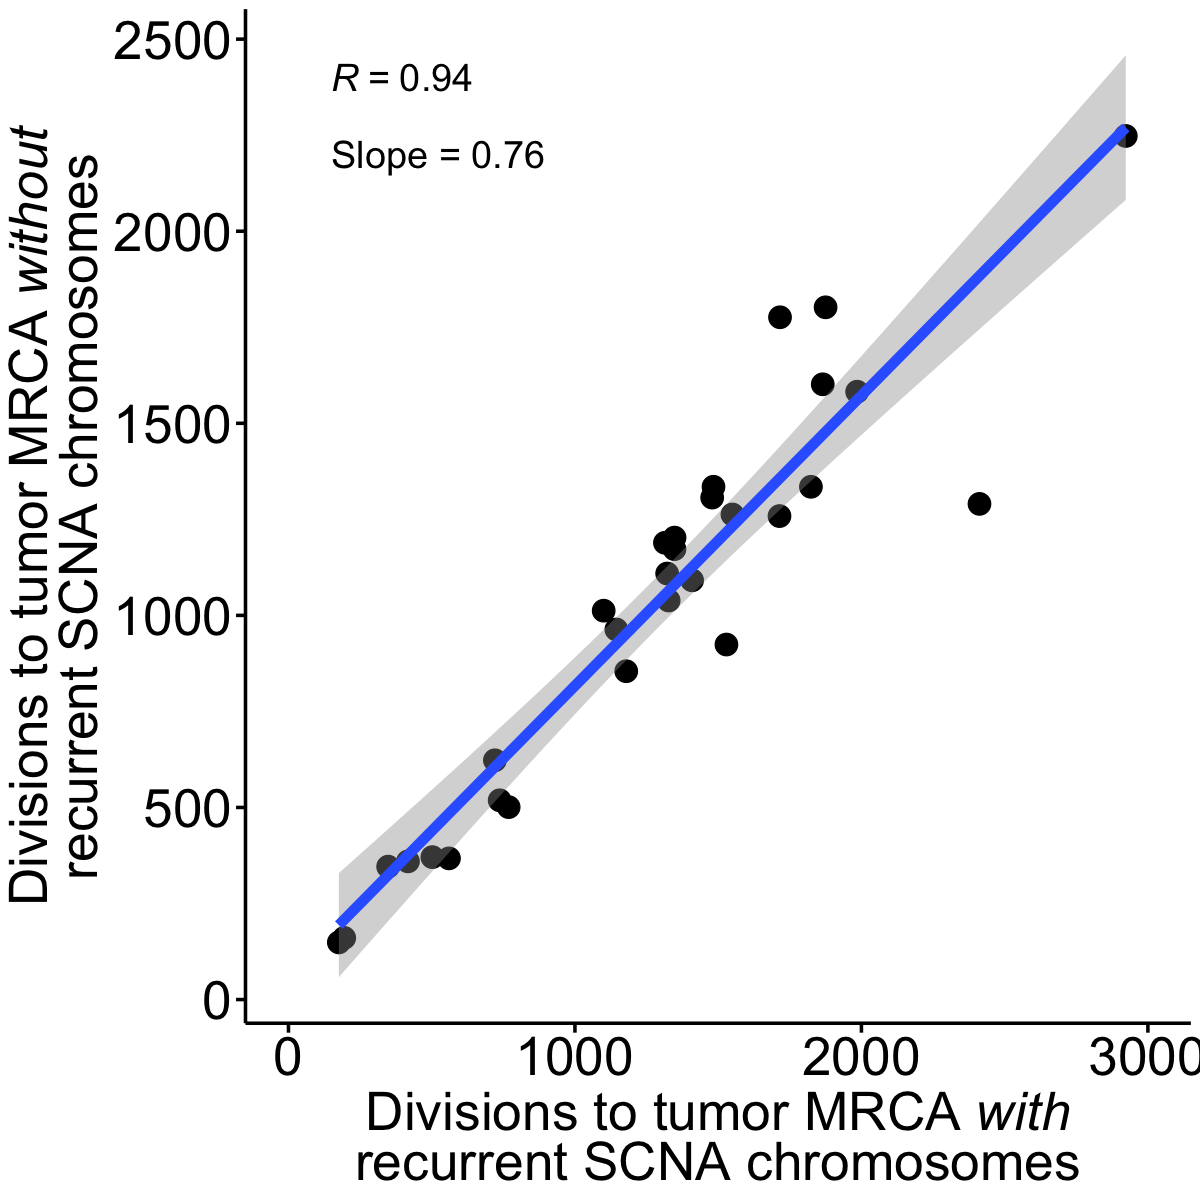

In [96]:
options(repr.plot.width=10, repr.plot.height=10)
mrca_no_cna %>%
    select(subject, all_mrca) %>%
    left_join(mrca_tbl %>%
    rename(all_mrca_no_cna = all_mrca)) %>%
    filter(!subject %in%  c("C92", "C95", "C6", "C38","C12","C102","C11")) %>% 
        ggplot(aes(all_mrca, all_mrca_no_cna)) +
        geom_point(size = 6) +
        geom_smooth(method = "lm", size = 3) +
        stat_cor(aes(label = ..r.label..), size = 8, hjust = 0, label.x = 150, label.y = 2400) +
        annotate("text", x = 150, y = 2200, label = slope, size = 8, hjust = 0) +
        coord_cartesian(xlim=c(0, 3000)) +
        labs(x="Divisions to tumor MRCA *with*<br>recurrent SCNA chromosomes", y="Divisions to tumor MRCA *without*<br>recurrent SCNA chromosomes") +
        theme_martin() +
        theme(axis.title.x = element_markdown(),
        axis.title.y = element_markdown()
        )
    ggsave("../plots/Figure3/Extended_Data_Fig2a.pdf", height=11, width=11)

## Change of divsion rate through SCNA

In [105]:
natgen_age <- read_xlsx("../data/Reiter_2020_Supplementary_Tables.xlsx", sheet=3,
                skip=1)  %>% 
    rename(subject = 2, age = 4, size = 16) %>%
    select(subject, age, size) %>%
    mutate(age = parse_number(age))    
science_age <-  read_xlsx("../data/Naxerova_2017_patient_information.xlsx") %>%
     rename(subject = Patient, size=`Tumor size`, age=`Age at dianosis`) %>%
     select(subject, age, size) %>% 
     filter(subject!="C57")
clinical_tbl <- bind_rows(science_age, natgen_age)

crc_mrca_clinical <- mrca_tbl %>%
    left_join(clinical_tbl) 


New names:
* `` -> `...1`
Joining with `by = join_by(subject)`


Numbers for text: reduced turnover when removing SCNA.

In [109]:
crc_mrca_clinical %>%
  pivot_longer(c(all_mrca, ad_ad_mrca), values_to = "divs", names_to = "group") %>%
  select(subject, divs, age, group) %>%
  filter(!subject %in%  c("C92", "C95", "C6", "C38","C12","C102","C11"), group=="all_mrca") %>% 
  mutate(age=age-5) %>% 
  mutate(divs_per_year=divs/age)  %>% 
  mutate(days_per_divs=365/divs_per_year)  %>%  
  summarize(
    n = n(),
    median = median(days_per_divs),
    mean = mean(days_per_divs),
    max = max(days_per_divs)
  ) 

n,median,mean,max
<int>,<dbl>,<dbl>,<dbl>
30,19.80969,30.30028,156.8664
